<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

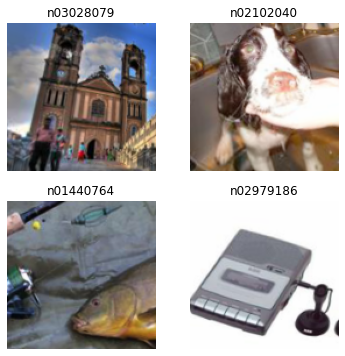

In [6]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks=(ImageBlock, CategoryBlock), 
      get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y=parent_label,
      item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=.5, size=resize), Normalize.from_stats(*imagenet_stats)],
  ).dataloaders(path, bs=128)
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

In [10]:
#Make a fully convolutional network
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
  return nn.Sequential(
      block(3,16),
      block(16,32),
      block(32,64),
      block(64,128),
      block(128,256),
      nn.AdaptiveAvgPool2d(1),
      Flatten(),
      nn.Linear(256, dls.c))

SuggestedLRs(valley=0.015848932787775993)

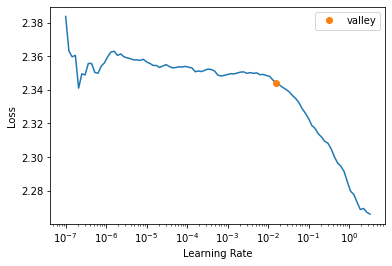

In [11]:
def get_learner(m):
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
learn = get_learner(get_model())
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.331830,2.307441,0.131210,00:26
1,2.267082,2.236369,0.202293,00:26
2,2.213340,2.197006,0.219618,00:26
3,2.183186,2.179616,0.228535,00:27
4,2.168975,2.178408,0.228025,00:26


In [13]:
def _conv_block(ni,nf,stride):
  return nn.Sequential(
      ConvLayer(ni,nf,stride=stride),
      ConvLayer(nf,nf, act_cls=None, norm_type=NormType.BatchZero)
  )

class ResBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.convs = _conv_block(ni, nf, stride)
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

  def forward(self, x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [14]:
#replace block with resblock
def block(ni, nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.314445,2.227494,0.182675,00:30
1,2.164053,2.084486,0.278217,00:32
2,2.068565,2.016855,0.316433,00:35
3,2.013830,1.990049,0.323057,00:28
4,1.991566,1.985547,0.326115,00:28


In [15]:
#Let's make model twice as deep
def block(ni,nf):
  return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf,nf))
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.278432,2.193762,0.204331,00:32
1,2.128376,2.038976,0.314650,00:30
2,2.015620,1.962265,0.336815,00:30
3,1.950750,1.929818,0.355159,00:29
4,1.932119,1.924524,0.358981,00:29
